# Imputation

Going from the end of format_data.ipynb, a new version of the data set was saved which converts and drops columns as needed. 5 columns still had empty values, so the imputations will be done in this file.

# Funded Amount
With just over 5% of the values being missing, imputation can be performed. The first step is to look at a histogram of the column, as well as the mean, median, and mode:

The mode of the distribution is 10000.0
The mean of the distribution is 13229.50911682024
The median of the distribution is 12000.0


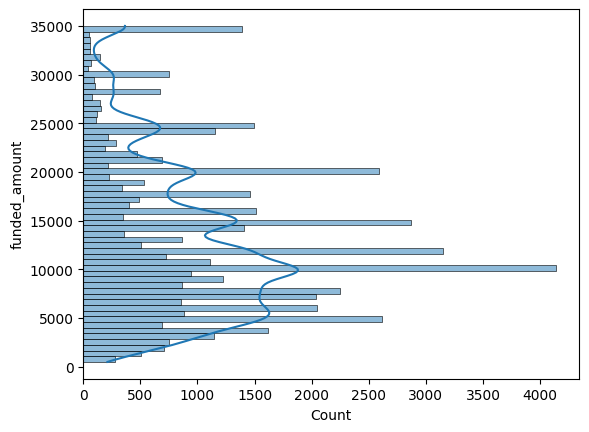

In [1]:
import pandas as pd
import seaborn as sns
df = pd.read_csv('transformed_data.csv')

#df['funded_amount'].hist(bins=40)
sns.histplot(data=df, y='funded_amount', kde=True)

print(f"The mode of the distribution is {df['funded_amount'].mode()[0]}")
print(f"The mean of the distribution is {df['funded_amount'].mean()}")
print(f"The median of the distribution is {df['funded_amount'].median()}")



We can see a slight positive skew in the data, and the mean, median, and mode are somewhat similar. Let's check to see if these missing values are randomly distributed, or there is some potential patterns. 

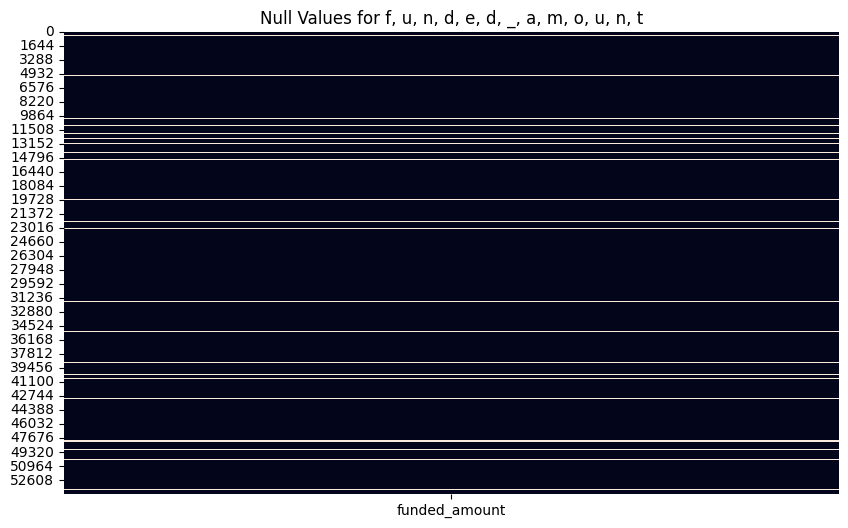

In [2]:
from data_imputer import Plotter

plotter = Plotter(df)
plotter.plot_null_values('funded_amount')

It's again hard to make any concrete conclusions here from both the histogram and the spread of the nulls. It is probably safe to impute the median, but let's quickly check a correlation matrix for funded_amount. This will also be used to check the other columns with nulls.

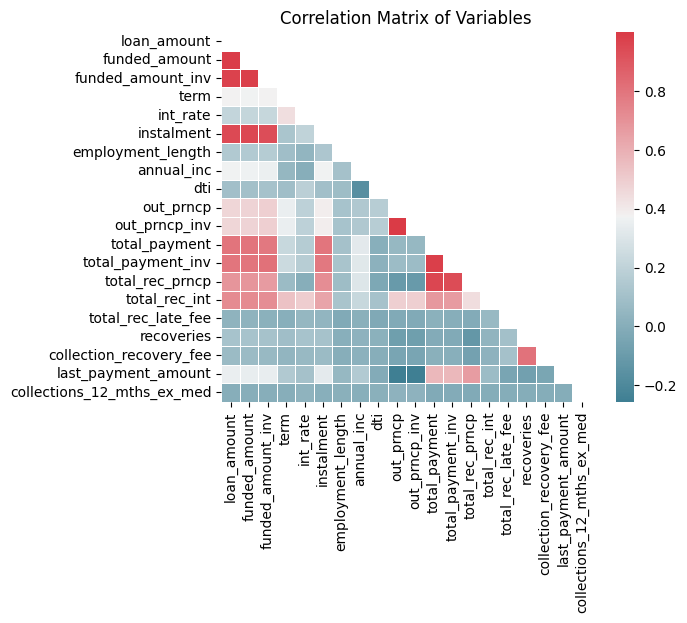

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Select only columns with float data types
int_columns = df.select_dtypes(include='float').columns
df_int = df[int_columns]

# Compute correlation matrix
corr = df_int.corr()

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of Variables')
plt.show()


So as it turns out, there is quite a strong correlation between funded_amount and funded_amount_inv, but funded_amount_inv does not have any missing values. Here, we are now safe to impute the median:

In [4]:
from data_imputer import DataFrameTransform

transformer = DataFrameTransform(df)
transformer.impute_missing_values('funded_amount', method='median')


Let's now check we were successful

In [5]:
df['funded_amount'].isnull().sum()

0

# Term

The next column with missing values is the term column, which had over 8% of the values missing. This is on the upper side when it comes to imputing null values. Let's check out the kind of data in the column first.

In [6]:
df['term'].value_counts()

term
36.0    35845
60.0    13614
Name: count, dtype: int64

This presents an interesting problem, as the entries in this column are binary, either 36 months or 60 months. Looking at the correlation matrix, there is not a particularly strong correlation between any other column. One of the highest correlations being the interest rate is potentially of interest, as there is also null values in this column.  Let's check for a correlation.

<Axes: >

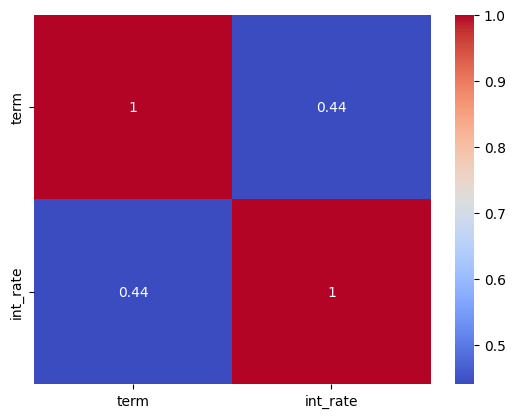

In [7]:
sns.heatmap(df[['term', 'int_rate']].corr(), annot=True, cmap='coolwarm')

44% is not a very large amount of correlation. Just in case, we can perform a chi-squared test.

In [8]:
from scipy.stats import chi2_contingency

# Step 1: Create a new column indicating whether A is missing
df['missing'] = df['term'].isnull()

# Step 2: Crosstab the new column with B
contingency_table = pd.crosstab(df['missing'], df['int_rate'])

# Step 3: Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic = {chi2}")
print(f"p-value = {p}")

Chi-square statistic = 395.6425788150139
p-value = 0.9808667812725932


So these columns are not correlated. Here, our best option may be to simply drop the column. As a final check, let's see if the distribution of missing values is missing at random, or there is a more systematic method here, for columns with similar numbers of null values.

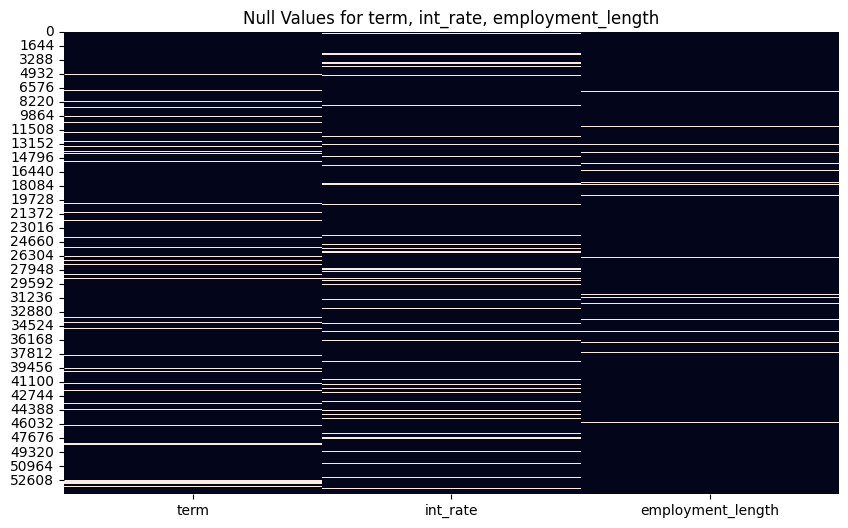

In [9]:
#null_columns = ['term', 'int_rate']

plotter.plot_null_values(['term', 'int_rate', 'employment_length'])

No clear correlations. This is quite an issue, the remaining choices are to either drop the entire column, or lose all the rows with the missing term. We will likely need the term column later in milestone 4, so let's remove the rows with no term.

In [10]:
#drop = DataFrameTransform(df)
#drop.drop_columns('term')

#df = drop.data

df.dropna(subset=['term'], inplace=True)

# Interest Rate
The next column with missing values. Over 9% of values are missing, so careful consideration is needed whether this column is dropped or imputed. Interest rate is of course an important statistic for the loan, so it is hard to think this will be dropped. Anyways, let's look at the histogram.

<Axes: xlabel='Count', ylabel='int_rate'>

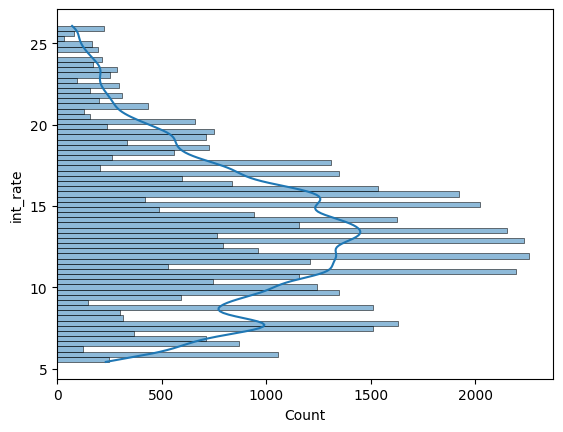

In [11]:
sns.histplot(data=df, y='int_rate', kde=True)

A fairly smooth distribution, and looking at the correlation matrix, this does not appear to be very correlated with other columns. Let's check the statistical values.

In [12]:
print(f"The mode of the distribution is {df['int_rate'].mode()[0]}")
print(f"The mean of the distribution is {df['int_rate'].mean()}")
print(f"The median of the distribution is {df['int_rate'].median()}")

The mode of the distribution is 11.99
The mean of the distribution is 13.507328482328484
The median of the distribution is 13.16


All very similar. Let's use the median here.

In [13]:
transformer = DataFrameTransform(df)
transformer.impute_missing_values('int_rate', method='median')

# Employment Length 

This is an interesting column to try and fix. As a reminder, 3.9% of the columns have some missing data, so dropping the column is not a valid option.
Let's begin by looking at the value coints to determine why:

In [14]:
df['employment_length'].value_counts()

employment_length
10.0    15907
1.0      8742
2.0      5066
3.0      4589
5.0      3836
4.0      3482
6.0      3059
7.0      2964
8.0      2537
9.0      1931
Name: count, dtype: int64

This presents an issue as 10+ is a very broad range of years, but it is by far the most common value present in the column. This means we do not know the true mean, median, or standard deviation.
If we look at these values, here is what we get:

In [15]:
print(f"The mode of the distribution is {df['employment_length'].mode()[0]}")
print(f"The mean of the distribution is {df['employment_length'].mean()}")
print(f"The median of the distribution is {df['employment_length'].median()}")

The mode of the distribution is 10.0
The mean of the distribution is 5.7873467273041275
The median of the distribution is 6.0


As mentioned in the previous file, this column is somewhat awkward and this is the result for merging all results for 10+ years into one column. Regardless, I'm making the decision to impute with the median here, as it provides a decent middle ground, and allows the nulls to be removed.

In [16]:
transformer.impute_missing_values('employment_length', method='median')

# Last Payment Date & Last Credit Pull Date

These two columns have less than 0.2% of the values missing. Since these are dates, the safest thing to do is to remove the rows with the nulls here, as we are losing very little data.

In [17]:
df = df.dropna(subset=['last_payment_date'])
df = df.dropna(subset=['last_credit_pull_date'])

# Collections 12 Months ex. Med

Finally onto the last column with nulls, collections_12_mths_ex_med, which is the number of collections in 12 month exclusing medical collections. Looking at the correlation matrix, this has almost no correlations with other columns, and with just under 0.1% of nulls, this seems like an easy target for the median or mean imputation. 
Let's check the value counts to know what we're working with:

In [18]:
df["collections_12_mths_ex_med"].value_counts()
#sns.histplot(data=df, y='collections_12_mths_ex_med', kde=True)

print(f"The mode of the distribution is {df['collections_12_mths_ex_med'].mode()[0]}")
print(f"The mean of the distribution is {df['collections_12_mths_ex_med'].mean()}")
print(f"The median of the distribution is {df['collections_12_mths_ex_med'].median()}")


The mode of the distribution is 0.0
The mean of the distribution is 0.004195933456561923
The median of the distribution is 0.0


This column likely has the majority of results as 0. Looking at the histogram to confirm this:

<Axes: >

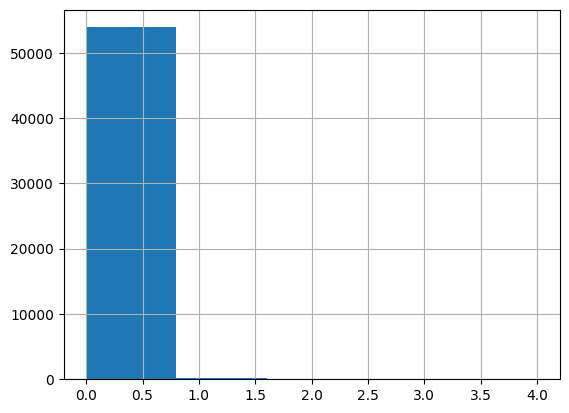

In [19]:
df['collections_12_mths_ex_med'].hist(bins=5)

Let's impute with the median then. With such a large majority of entries being 0, this should be a reasonable approach.

In [20]:
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].fillna(df['collections_12_mths_ex_med'].median())

We can now do a final check to make sure all the nulls have been removed from the dataset:

In [23]:
from data_info import DataFrameInfo

missing_values = DataFrameInfo()
missing_values.percentage_of_missing(df, threshold=0)

Series([], dtype: float64)

We are now left with no more nulls! Next, the skew of the columns will be examined. This is followed up on skew_correcting.ipynb

In [22]:
df.to_csv('nulls_removed.csv', index=False)

Note: this is the dataset that will be used to tackle Milestone 4!